# Masinsko ucenje - projekat

Dataset: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008
 
Klasifikacija - Predviđanje ponovne hospitalizacije pacijenta sa dijabetesom na osnovu podataka sa inicijalne hospitalizacije

1.   Priprema podataka

In [1]:
import pandas as pd
import sklearn as scikit
import numpy as np
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
import copy
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "../dataset/diabetic_data.csv"
dataframe = pd.read_csv(path, low_memory=False, na_values=[
                        "?", "Unknown/Invalid"])
pd.set_option("display.max_columns", None)
dataframe.head(3)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO


In [3]:
total_rows = dataframe.shape[0]
dataframe.shape


(101766, 50)

In [4]:
dataframe["readmitted"].value_counts()


NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [5]:
missing = dataframe.isna()
missing_count = missing.sum()
treshold = 0.2
to_drop = []
for i in range(0, missing_count.count()):
    if missing_count[i] / total_rows > treshold:
        to_drop.append(i)
for i in to_drop:
    print(i, dataframe.columns[i])
dataframe = dataframe.drop(dataframe.columns[to_drop], axis=1)
dataframe.shape


5 weight
10 payer_code
11 medical_specialty


(101766, 47)

In [6]:
dataframe.dropna(inplace=True)
dataframe.drop(
    dataframe[
        [
            "encounter_id",
            "patient_nbr",
            "examide",
            "citoglipton",
            "metformin-rosiglitazone",
        ]
    ],
    axis=1,
    inplace=True,
)


In [7]:
print("Number Of Rows In The Original DataFrame:", len(dataframe))
print("Number Of Rows After Deduping:", len(dataframe.drop_duplicates()))


Number Of Rows In The Original DataFrame: 98052
Number Of Rows After Deduping: 98052


In [8]:
dataframe.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      98052 non-null  object
 1   gender                    98052 non-null  object
 2   age                       98052 non-null  object
 3   admission_type_id         98052 non-null  int64 
 4   discharge_disposition_id  98052 non-null  int64 
 5   admission_source_id       98052 non-null  int64 
 6   time_in_hospital          98052 non-null  int64 
 7   num_lab_procedures        98052 non-null  int64 
 8   num_procedures            98052 non-null  int64 
 9   num_medications           98052 non-null  int64 
 10  number_outpatient         98052 non-null  int64 
 11  number_emergency          98052 non-null  int64 
 12  number_inpatient          98052 non-null  int64 
 13  diag_1                    98052 non-null  object
 14  diag_2               

Diagnose mapping http://icd9cm.chrisendres.com/index.php?action=contents

In [9]:
def diag_mapper(value: str) -> int:
    try:
        int_value = int(float(value))
        if int_value <= 139:
            return 'Infectious and Parasitic'
        elif int_value <= 239:
            return 'Neoplasms'
        elif int_value <= 279:
            return 'Metabolic'
        elif int_value <= 289:
            return 'Blood'
        elif int_value <= 319:
            return 'Mental'
        elif int_value <= 389:
            return 'Nervous System'
        elif int_value <= 459:
            return 'Circulatory System'
        elif int_value <= 519:
            return 'Respiratory System'
        elif int_value <= 579:
            return 'Digestive System'
        elif int_value <= 629:
            return 'Genitourinary System'
        elif int_value <= 679:
            return 'Pregnancy'
        elif int_value <= 709:
            return 'Skin'
        elif int_value <= 739:
            return 'Musculoskeletal'
        elif int_value <= 759:
            return 'Congenital'
        elif int_value <= 779:
            return 'Perinatal Period'
        elif int_value <= 799:
            return 'Ill Defined'
        else:
            return 'Injury'
    except ValueError:
        if value[0] == 'V':
            return 'Status'
        else:  # E
            return 'Cause'


dataframe['diag_1_class'] = dataframe['diag_1'].apply(lambda x: diag_mapper(x))
dataframe['diag_2_class'] = dataframe['diag_2'].apply(lambda x: diag_mapper(x))
dataframe['diag_3_class'] = dataframe['diag_3'].apply(lambda x: diag_mapper(x))


In [10]:
age_scale_mapper = {
    '[0-10)': 0,
    '[10-20)': 1,
    '[20-30)': 2,
    '[30-40)': 3,
    '[40-50)': 4,
    '[50-60)': 5,
    '[60-70)': 6,
    '[70-80)': 7,
    '[80-90)': 8,
    '[90-100)': 9,
}
glu_scale_mapper = {
    'None': 70,
    'Norm': 70,
    '>200': 250,
    '>300': 350
}
a1_scale_mapper = {
    'None': 4,
    'Norm': 4,
    '>7': 7,
    '>8': 9,
}
level_scale_mapper = {
    'No': 0,
    'Steady': 2,
    'Up': 3,
    'Down': 1
}
class_mapper = {
    'NO': 0,
    '<30': 1,
    '>30': 2
}
race_mapper = {
    "Other": 0,
    "Caucasian": 1,
    "AfricanAmerican": 2,
    "Hispanic": 3,
    "Asian": 4,
}
diagnum_mapper = {
    'Infectious and Parasitic': 0,
    'Neoplasms': 1,
    'Metabolic': 2,
    'Blood': 3,
    'Mental': 4,
    'Nervous System': 5,
    'Circulatory System': 6,
    'Respiratory System': 7,
    'Digestive System': 8,
    'Genitourinary System': 9,
    'Pregnancy': 10,
    'Skin': 11,
    'Musculoskeletal': 12,
    'Congenital': 13,
    'Perinatal Period': 14,
    'Ill Defined': 15,
    'Injury': 16,
    'Status': 17,
    'Cause': 18,
}

one_hot = LabelBinarizer()

dataframe['admission_type_id'] = dataframe['admission_type_id'].astype(
    'category')
dataframe['discharge_disposition_id'] = dataframe['discharge_disposition_id'].astype(
    'category')
dataframe['admission_source_id'] = dataframe['admission_source_id'].astype(
    'category')

dataframe['age'] = dataframe['age'].replace(age_scale_mapper)
dataframe['gender'] = one_hot.fit_transform(dataframe['gender'])
dataframe['max_glu_serum'] = dataframe['max_glu_serum'].replace(
    glu_scale_mapper)
dataframe['A1Cresult'] = dataframe['A1Cresult'].replace(a1_scale_mapper)
dataframe['metformin'] = dataframe['metformin'].replace(level_scale_mapper)
dataframe['repaglinide'] = dataframe['repaglinide'].replace(level_scale_mapper)
dataframe['nateglinide'] = dataframe['nateglinide'].replace(level_scale_mapper)
dataframe['chlorpropamide'] = dataframe['chlorpropamide'].replace(
    level_scale_mapper)
dataframe['glimepiride'] = dataframe['glimepiride'].replace(level_scale_mapper)
dataframe['acetohexamide'] = dataframe['acetohexamide'].replace(
    level_scale_mapper)
dataframe['glipizide'] = dataframe['glipizide'].replace(level_scale_mapper)
dataframe['glyburide'] = dataframe['glyburide'].replace(level_scale_mapper)
dataframe['tolbutamide'] = dataframe['tolbutamide'].replace(level_scale_mapper)
dataframe['pioglitazone'] = dataframe['pioglitazone'].replace(
    level_scale_mapper)
dataframe['rosiglitazone'] = dataframe['rosiglitazone'].replace(
    level_scale_mapper)
dataframe['acarbose'] = dataframe['acarbose'].replace(level_scale_mapper)
dataframe['miglitol'] = dataframe['miglitol'].replace(level_scale_mapper)
dataframe['troglitazone'] = dataframe['troglitazone'].replace(
    level_scale_mapper)
dataframe['tolazamide'] = dataframe['tolazamide'].replace(level_scale_mapper)
dataframe['insulin'] = dataframe['insulin'].replace(level_scale_mapper)
dataframe['glyburide-metformin'] = dataframe['glyburide-metformin'].replace(
    level_scale_mapper)
dataframe['glipizide-metformin'] = dataframe['glipizide-metformin'].replace(
    level_scale_mapper)
dataframe['glimepiride-pioglitazone'] = dataframe['glimepiride-pioglitazone'].replace(
    level_scale_mapper)
dataframe['metformin-pioglitazone'] = dataframe['metformin-pioglitazone'].replace(
    level_scale_mapper)
dataframe['change'] = one_hot.fit_transform(dataframe['change'])
dataframe['diabetesMed'] = one_hot.fit_transform(dataframe['diabetesMed'])
dataframe['readmitted'] = dataframe['readmitted'].replace(class_mapper)


In [11]:
dataframe_onehot = dataframe.copy(deep=True)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      98052 non-null  object  
 1   gender                    98052 non-null  int32   
 2   age                       98052 non-null  int64   
 3   admission_type_id         98052 non-null  category
 4   discharge_disposition_id  98052 non-null  category
 5   admission_source_id       98052 non-null  category
 6   time_in_hospital          98052 non-null  int64   
 7   num_lab_procedures        98052 non-null  int64   
 8   num_procedures            98052 non-null  int64   
 9   num_medications           98052 non-null  int64   
 10  number_outpatient         98052 non-null  int64   
 11  number_emergency          98052 non-null  int64   
 12  number_inpatient          98052 non-null  int64   
 13  diag_1                    98052 non-null  obj

In [12]:
def df_one_hot(df, columns):
    tmp = pd.DataFrame()
    for col in columns:
        res = one_hot.fit_transform(df[col])
        for val in range(0, len(res[0])):
            new_col = res[:, val]
            tmp_col = pd.DataFrame(
                {col + '(' + str(one_hot.classes_[val])+')': new_col})
            tmp = pd.concat((tmp, tmp_col), axis=1)
    return pd.concat((df.reset_index(drop=True), tmp.reset_index(drop=True)), axis=1, join='inner')


dataframe_onehot = df_one_hot(dataframe_onehot, ['diag_1_class', 'diag_2_class', 'diag_3_class',
                              'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'race'])
dataframe_onehot.drop(['diag_1_class', 'diag_2_class', 'diag_3_class', 'admission_type_id',
                      'discharge_disposition_id', 'admission_source_id', 'race'], axis=1, inplace=True)
dataframe_onehot.shape


(98052, 148)

In [13]:
dataframe['diag_1_class'] = dataframe['diag_1_class'].replace(diagnum_mapper)
dataframe['diag_2_class'] = dataframe['diag_2_class'].replace(diagnum_mapper)
dataframe['diag_3_class'] = dataframe['diag_3_class'].replace(diagnum_mapper)
dataframe['race'] = dataframe['race'].replace(race_mapper)

In [14]:
from sklearn.feature_selection import VarianceThreshold
import category_encoders as ce

def remove_low_variance_columns(df,target,treshold):

    y = df[target]
    X_cat = df.drop(columns=[target,'diag_1','diag_2','diag_3'])
    selector = VarianceThreshold(threshold=treshold)
    X_reduced = selector.fit_transform(X_cat, y)
    cols = selector.get_support(indices=True)
    selected_columns = X_cat.iloc[:, cols].columns.tolist()
    selected_columns.append(target)
    print(X_reduced.shape)
    return selected_columns



selected_columns=remove_low_variance_columns(dataframe_onehot,"readmitted",0.005)

to_drop = []
print("deleted columns:")

for col in dataframe_onehot.columns:
    if col not in selected_columns:
        print(col)
        to_drop.append(col)

# df.drop(df[to_drop], inplace=True, axis=1)
print(dataframe_onehot.shape)

(98052, 101)
deleted columns:
diag_1
diag_2
diag_3
chlorpropamide
acetohexamide
tolbutamide
miglitol
troglitazone
tolazamide
glipizide-metformin
glimepiride-pioglitazone
metformin-pioglitazone
diag_1_class(Cause)
diag_1_class(Congenital)
diag_2_class(Congenital)
diag_2_class(Pregnancy)
diag_3_class(Congenital)
diag_3_class(Pregnancy)
admission_type_id(4)
admission_type_id(7)
admission_type_id(8)
discharge_disposition_id(8)
discharge_disposition_id(9)
discharge_disposition_id(10)
discharge_disposition_id(12)
discharge_disposition_id(13)
discharge_disposition_id(14)
discharge_disposition_id(15)
discharge_disposition_id(16)
discharge_disposition_id(17)
discharge_disposition_id(19)
discharge_disposition_id(20)
discharge_disposition_id(23)
discharge_disposition_id(24)
discharge_disposition_id(27)
discharge_disposition_id(28)
admission_source_id(3)
admission_source_id(8)
admission_source_id(9)
admission_source_id(10)
admission_source_id(11)
admission_source_id(13)
admission_source_id(14)
adm

In [15]:
dataframe_onehot['diag_1_class(Cause)'].value_counts()

0    98051
1        1
Name: diag_1_class(Cause), dtype: int64

In [16]:
from math import ceil
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif

def select_best_columns(df,target,best_ratio):
    
    y = df[target]
    X_cat = df.drop(columns=[target,'diag_1','diag_2','diag_3'])
    X = X_cat
    print(X.shape)
    selector = SelectKBest(mutual_info_classif, k=ceil(X.shape[1]*best_ratio))
    X_reduced = selector.fit_transform(X, y)
    cols = selector.get_support(indices=True)
    selected_columns = X.iloc[:, cols].columns.tolist()
    selected_columns.append(target)

    print(X_reduced.shape)

    return selected_columns

selected = select_best_columns(dataframe_onehot,"readmitted",0.8)

to_drop = []
print("deleted columns:")

for col in dataframe_onehot.columns:
    if col not in selected:
        print(col)
        to_drop.append(col)

#df.drop(df[to_drop], inplace=True, axis=1)
print(dataframe_onehot.shape)


(98052, 144)
(98052, 116)
deleted columns:
diag_1
diag_2
diag_3
metformin
nateglinide
glimepiride
acetohexamide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
glimepiride-pioglitazone
metformin-pioglitazone
diag_1_class(Blood)
diag_1_class(Cause)
diag_1_class(Digestive System)
diag_1_class(Genitourinary System)
diag_1_class(Mental)
diag_1_class(Pregnancy)
diag_1_class(Skin)
diag_2_class(Blood)
diag_2_class(Cause)
diag_2_class(Congenital)
diag_2_class(Digestive System)
diag_2_class(Genitourinary System)
diag_2_class(Ill Defined)
diag_2_class(Mental)
(98052, 148)


In [17]:
print(dataframe.shape)
dataframe.head()


(98052, 45)


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_class,diag_2_class,diag_3_class
1,1,0,1,1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,70,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,2,276,250.01,255
2,2,0,2,1,1,7,2,11,5,13,2,0,1,648,250,V27,6,70,4,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,648,250,V27
3,1,1,3,1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,70,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,8,250.43,403
4,1,1,4,1,1,7,1,51,0,8,0,0,0,197,157,250,5,70,4,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,197,157,250
5,1,1,5,2,1,2,3,31,6,16,0,0,0,414,411,250,9,70,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,2,414,411,250


In [18]:
print(dataframe_onehot.shape)
dataframe_onehot.head()


(98052, 148)


,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_class(Blood),diag_1_class(Cause),diag_1_class(Circulatory System),diag_1_class(Congenital),diag_1_class(Digestive System),diag_1_class(Genitourinary System),diag_1_class(Ill Defined),diag_1_class(Infectious and Parasitic),diag_1_class(Injury),diag_1_class(Mental),diag_1_class(Metabolic),diag_1_class(Musculoskeletal),diag_1_class(Neoplasms),diag_1_class(Nervous System),diag_1_class(Pregnancy),diag_1_class(Respiratory System),diag_1_class(Skin),diag_1_class(Status),diag_2_class(Blood),diag_2_class(Cause),diag_2_class(Circulatory System),diag_2_class(Congenital),diag_2_class(Digestive System),diag_2_class(Genitourinary System),diag_2_class(Ill Defined),diag_2_class(Infectious and Parasitic),diag_2_class(Injury),diag_2_class(Mental),diag_2_class(Metabolic),diag_2_class(Musculoskeletal),diag_2_class(Neoplasms),diag_2_class(Nervous System),diag_2_class(Pregnancy),diag_2_class(Respiratory System),diag_2_class(Skin),diag_2_class(Status),diag_3_class(Blood),diag_3_class(Cause),diag_3_class(Circulatory System),diag_3_class(Congenital),diag_3_class(Digestive System),diag_3_class(Genitourinary System),diag_3_class(Ill Defined),diag_3_class(Infectious and Parasitic),diag_3_class(Injury),diag_3_class(Mental),diag_3_class(Metabolic),diag_3_class(Musculoskeletal),diag_3_class(Neoplasms),diag_3_class(Nervous System),diag_3_class(Pregnancy),diag_3_class(Respiratory System),diag_3_class(Skin),diag_3_class(Status),admission_type_id(1),admission_type_id(2),admission_type_id(3),admission_type_id(4),admission_type_id(5),admission_type_id(6),admission_type_id(7),admission_type_id(8),discharge_disposition_id(1),discharge_disposition_id(2),discharge_disposition_id(3),discharge_disposition_id(4),discharge_disposition_id(5),discharge_disposition_id(6),discharge_disposition_id(7),discharge_disposition_id(8),discharge_disposition_id(9),discharge_disposition_id(10),discharge_disposition_id(11),discharge_disposition_id(12),discharge_disposition_id(13),discharge_disposition_id(14),discharge_disposition_id(15),discharge_disposition_id(16),discharge_disposition_id(17),discharge_disposition_id(18),discharge_disposition_id(19),discharge_disposition_id(20),discharge_disposition_id(22),discharge_disposition_id(23),discharge_disposition_id(24),discharge_disposition_id(25),discharge_disposition_id(27),discharge_disposition_id(28),admission_source_id(1),admission_source_id(2),admission_source_id(3),admission_source_id(4),admission_source_id(5),admission_source_id(6),admission_source_id(7),admission_source_id(8),admission_source_id(9),admission_source_id(10),admission_source_id(11),admission_source_id(13),admission_source_id(14),admission_source_id(17),admission_source_id(20),admission_source_id(22),admission_source_id(25),race(AfricanAmerican),race(Asian),race(Caucasian),race(Hispanic),race(Other)
0,0,1,3,59,0,18,0,0,0,276,250.01,255,9,70,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,2,2,11,5,13,2,0,1,648,250,V27,6,70,4,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,3,2,44,1,16,0,0,0,8,250.43,403,7,70,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,

2.   Deskriptivna analiza

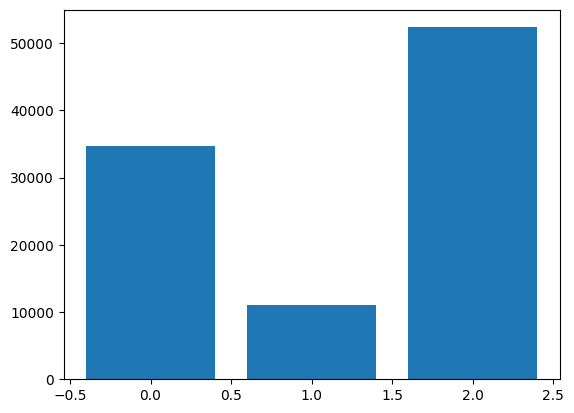

In [19]:
# names for categories
x = dataframe_onehot['readmitted'].unique()
# quantities for each category
y = dataframe_onehot['readmitted'].value_counts()
# create bar chart
plt.bar(x, y)
# show line plot
plt.show()


KeyboardInterrupt: 

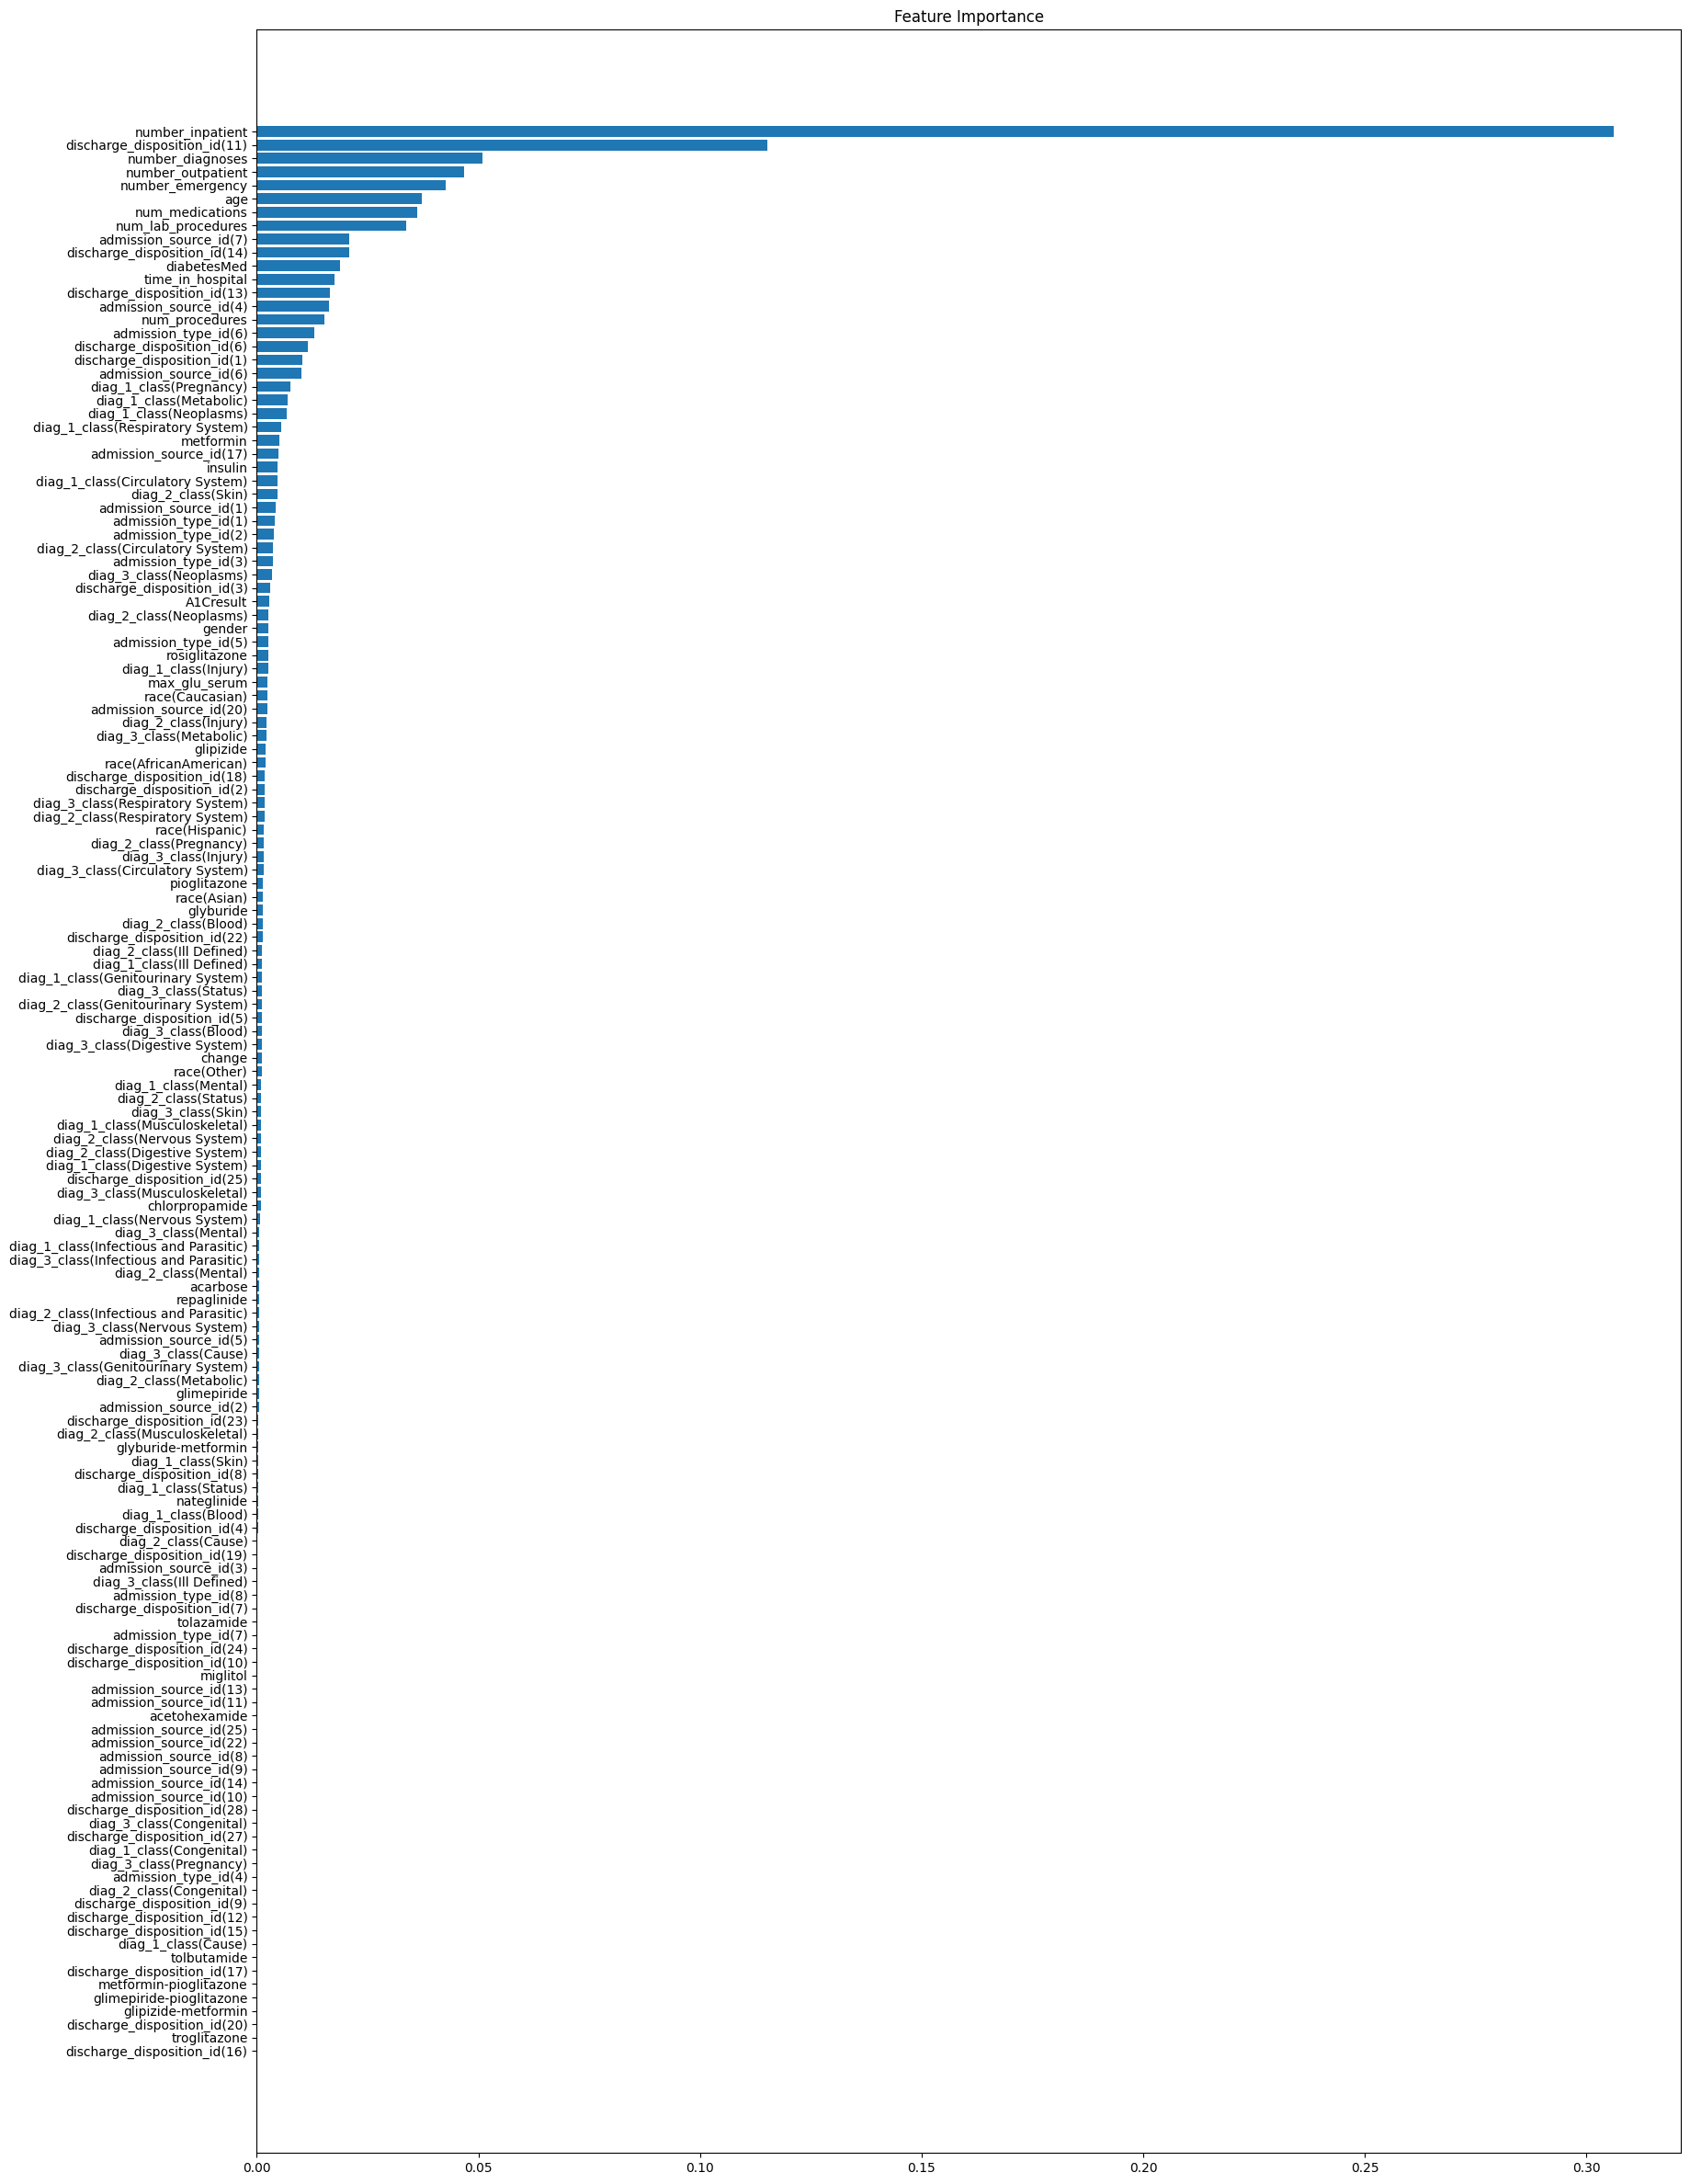

In [20]:
def feature_importance(df):
    target = 'readmitted'
    y = df[target]
    X = df.drop(columns=[target,'diag_1','diag_2','diag_3'])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.2, random_state=1066)
    encoder = ce.LeaveOneOutEncoder(return_df=True)
    X_train_loo = encoder.fit_transform(X_train, y_train)
    X_test_loo = encoder.transform(X_test)
    model = GradientBoostingRegressor(
        learning_rate=0.05, max_depth=5, n_estimators=500, min_samples_split=5, n_iter_no_change=10)
    model.fit(X_train_loo, y_train)

    rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test_loo)))
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(20, 30))
    plt.barh(range(len(sorted_idx)),
             feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.title('Feature Importance')

    perm_importance = permutation_importance(
        model, X_test_loo, y_test, n_repeats=10, random_state=1066)
    sorted_idx = perm_importance.importances_mean.argsort()
    fig = plt.figure(figsize=(20, 30))
    plt.barh(range(len(sorted_idx)),
             perm_importance.importances_mean[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.title('Permutation Importance')

    explainer = shap.Explainer(model)
    shap_values = explainer(X_test_loo)
    shap_importance = shap_values.abs.mean(0).values
    sorted_idx = shap_importance.argsort()
    fig = plt.figure(figsize=(20, 30))
    plt.barh(range(len(sorted_idx)),
             shap_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
    plt.title('SHAP Importance')

feature_importance(dataframe_onehot)
